In [6]:
import numpy
import torch
import mne
import matplotlib as plt 
import os 

# Importation & Pre-processing

In [ ]:
import os
import mne

# Chemin vers le dossier parent
dossier_parent = "./eeg_data"

# Dictionnaire pour stocker les données MNE par sous-dossier
donnees_par_sous_dossier = {}

# Parcours des sous-dossiers
for nom_sous_dossier in os.listdir(dossier_parent):
    # Construction du chemin complet du sous-dossier
    chemin_sous_dossier = os.path.join(dossier_parent, nom_sous_dossier)
    # Vérification si c'est un dossier
    if os.path.isdir(chemin_sous_dossier):
        # Initialisation de la liste des données MNE pour ce sous-dossier
        donnees_par_sous_dossier[nom_sous_dossier] = []
        # Parcours des fichiers dans ce sous-dossier
        for nom_fichier in os.listdir(chemin_sous_dossier):
            # Vérification si c'est un fichier .edf
            if nom_fichier.endswith('.edf'):
                # Ajout du chemin complet du fichier .edf
                chemin_fichier = os.path.join(chemin_sous_dossier, nom_fichier)
                # Lecture des données MNE
                donnees_mne = mne.io.read_raw_edf(chemin_fichier)
                # Stockage des données MNE dans la liste correspondante
                donnees_par_sous_dossier[nom_sous_dossier].append(donnees_mne)

# Affichage des informations sur les données MNE
for nom_sous_dossier, donnees_mne in donnees_par_sous_dossier.items():
    print(f"Sujet {nom_sous_dossier} : {len(donnees_mne)} fichiers .edf")




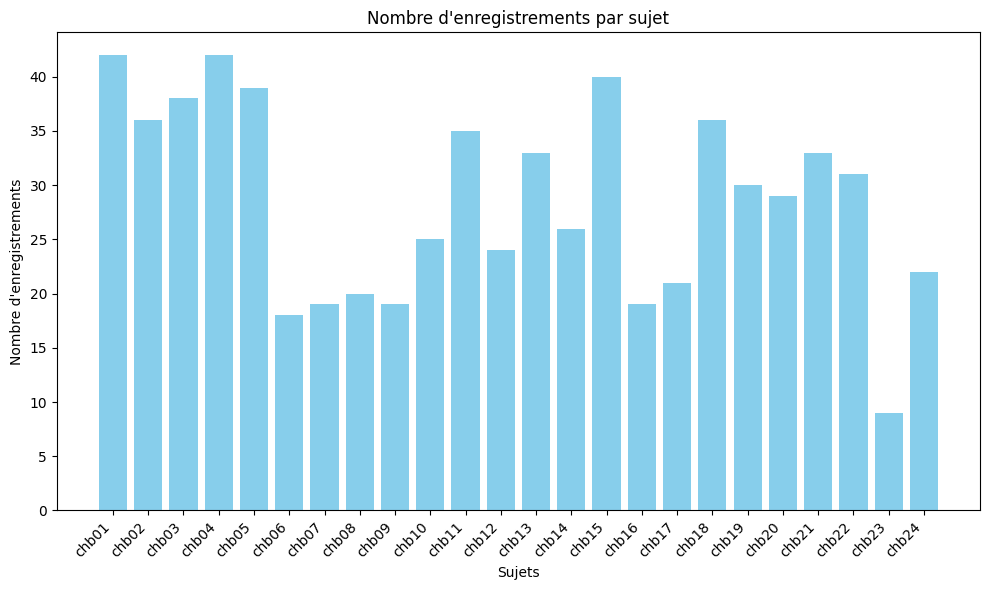

In [51]:
X = list(donnees_par_sous_dossier.keys())
Y = list(len(elem) for elem in donnees_par_sous_dossier.values())

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(X,Y, color='skyblue')
plt.xlabel('Sujets')
plt.ylabel('Nombre d\'enregistrements')
plt.title('Nombre d\'enregistrements par sujet')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
plt.tight_layout()  # Ajustement automatique du tracé pour éviter les chevauchements
plt.show()





### Temps d'échantillonnage - Nombre d'enregistrements n'ayant pas une durée de 1 heure par sujet 

In [ ]:
# Dictionnaire pour stocker le nombre de fichiers par sous-dossier
nombre_par_sous_dossier = {}

# Parcours des sous-dossiers
for nom_sous_dossier, donnees_mne_liste in donnees_par_sous_dossier.items():
    # Initialisation du compteur pour ce sous-dossier
    cpt = 0
    # Parcours des données MNE dans ce sous-dossier
    for donnees_mne in donnees_mne_liste:
        # Vérification si la durée de la donnée MNE est inférieure à la valeur donnée
        if donnees_mne.times[-1] < 3599.99609375:
            # Incrémentation du compteur
            cpt += 1
    # Stockage du nombre dans le dictionnaire
    nombre_par_sous_dossier[nom_sous_dossier] = cpt

# Affichage du nombre de fichiers qui satisfont la condition pour chaque sous-dossier
for nom_sous_dossier, nombre in nombre_par_sous_dossier.items():
    print(f"Sous-dossier {nom_sous_dossier} : {nombre} fichiers")
